In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler

Load dataset

In [3]:
fileName = 'complete_dataset.csv'
demand_dataset = pd.read_csv(fileName)

Data preprocessing - change school_day and holiday into binary variable

In [4]:

demand_dataset['school_day'] = demand_dataset['school_day'].replace({'Y':1, 'N':0})
demand_dataset['holiday'] = demand_dataset['holiday'].replace({'Y':1, 'N':0})
demand_dataset[25:30]


,date,demand,RRP,demand_pos_RRP,RRP_positive,demand_neg_RRP,RRP_negative,frac_at_neg_RRP,min_temperature,max_temperature,solar_exposure,rainfall,school_day,holiday
25,2015-01-26,103769.480,16.936013,103769.480,16.936013,0.0,0.0,0.0,11.6,19.8,19.9,1.0,0,1
26,2015-01-27,118393.310,21.206289,118393.310,21.206289,0.0,0.0,0.0,11.7,19.1,17.7,0.6,0,0
27,2015-01-28,116763.725,17.023838,116763.725,17.023838,0.0,0.0,0.0,13.3,25.4,27.0,0.0,0,0
28,2015-01-29,119313.730,19.624827,119313.730,19.624827,0.0,0.0,0.0,12.8,22.2,28.9,0.0,1,0
29,2015-01-30,121018.150,21.029356,121018.150,21.029356,0.0,0.0,0.0,13.1,21.0,27.6,0.0,1,0


Fill missing values

In [5]:
df = demand_dataset.drop(['date'], axis=1)
df.at[161, 'rainfall'] = 0
df.at[1377, 'rainfall'] = 0.4
df.at[1378, 'rainfall'] = 3.4
df['solar_exposure'].fillna(method = 'ffill', inplace = True)
print(df.isnull().sum())

demand             0
RRP                0
demand_pos_RRP     0
RRP_positive       0
demand_neg_RRP     0
RRP_negative       0
frac_at_neg_RRP    0
min_temperature    0
max_temperature    0
solar_exposure     0
rainfall           0
school_day         0
holiday            0
dtype: int64


C:\Users\AB\AppData\Local\Temp\ipykernel_23388\3896398393.py:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['solar_exposure'].fillna(method = 'ffill', inplace = True)


Scale the data into standard deviation

In [6]:
scaled_df=MinMaxScaler().fit_transform(df[['demand',
                                            'RRP',
                                      #      'demand_pos_RRP',
                                      #      'demand_neg_RRP',
                                            'min_temperature',
                                            'max_temperature',
                                            'solar_exposure',
                                            'rainfall']])
scaled_df=pd.DataFrame(scaled_df, columns=['demand',
                                           'RRP',
                                       #    'demand_pos_RRP',
                                       #     'demand_neg_RRP',
                                            'min_temperature',
                                            'max_temperature',
                                            'solar_exposure',
                                            'rainfall'])
scaled_df['holiday'] = df['holiday']
scaled_df['school_day'] = df['school_day']
scaled_df[1491:1500]

,demand,RRP,min_temperature,max_temperature,solar_exposure,rainfall,holiday,school_day
1491,0.294331,0.024935,0.605839,0.362319,0.831288,0.120879,0,1
1492,0.225906,0.027166,0.437956,0.440580,0.861963,0.000000,0,1
1493,0.463475,0.054224,0.525547,0.736232,0.822086,0.000000,0,1
1494,0.563272,0.042363,0.675182,0.846377,0.779141,0.000000,0,1
1495,0.398256,0.025512,0.708029,0.397101,0.263804,0.000000,0,1
1496,0.404487,0.021682,0.624088,0.518841,0.426380,0.000000,0,1
1497,0.647543,0.032823,0.653285,0.744928,0.677914,0.000000,0,1
1498,0.660350,0.033752,0.733577,0.559420,0.748466,0.201465,0,1
1499,0.376734,0.025007,0.638686,0.408696,0.625767,0.000000,0,1


Create function to convert the dataframe into the Train and Test set

In [7]:
def convert_to_X_y(dataframe, window, forecasting_time):
    dataframe = dataframe.to_numpy()
    X = []
    y = []
    for i in range (window, len(dataframe) - forecasting_time + 1):
        X.append(dataframe[i - window:i, 0: dataframe.shape[1]])
        y.append(dataframe[i+forecasting_time - 1: i+ forecasting_time, 0])
    return np.array(X), np.array(y)

Convert the dataframe

In [8]:
window_size = 7
forecasting_time = 1
X, y = convert_to_X_y(scaled_df, window_size, forecasting_time)
X.shape, y.shape

((2099, 7, 8), (2099, 1))

Train test split

In [9]:
X_train, y_train = X[:1461], y[:1461]
X_test, y_test = X[1461:2099], y[1461:2099]
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1461, 7, 8), (1461, 1), (638, 7, 8), (638, 1))

In [10]:
from keras.models import Sequential
from keras.layers import *
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
 
lstm_model = Sequential()
lstm_model.add(LSTM(64, activation='relu', input_shape=(X.shape[1], X.shape[2]), return_sequences= True))
lstm_model.add(LSTM(32, activation='relu', return_sequences=False))
lstm_model.add(Dense(y.shape[1], activation = 'linear'))

lstm_model.summary()
cp = ModelCheckpoint('lstm_model/', save_best_only=True)
lstm_model.compile(loss = 'mse',
                    optimizer=Adam(learning_rate=0.001),
                    metrics = [RootMeanSquaredError()])
lstm_model.fit(X_train, y_train, epochs=50, batch_size= 10, validation_data=(X_test, y_test), verbose= 1, callbacks = [cp])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 7, 64)             18688     
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 31137 (121.63 KB)
Trainable params: 31137 (121.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
146/147 [============================>.] - ETA: 0s - loss: 0.0365 - root_mean_squared_error: 0.1910INFO:tensorflow:Assets written to: lstm_model\assets


INFO:tensorflow:Assets written to: lstm_model\assets


147/147 [==============================] - 6s 17ms/step - loss: 0.0365 - root_mean_squared_error: 0.1910 - val_loss: 0.0211 - val_root_mean_squared_error: 0.1452
Epoch 2/50
133/147 [==========================>...] - ETA: 0s - loss: 0.0195 - root_mean_squared_error: 0.1395INFO:tensorflow:Assets written to: lstm_model\assets


INFO:tensorflow:Assets written to: lstm_model\assets


147/147 [==============================] - 2s 11ms/step - loss: 0.0192 - root_mean_squared_error: 0.1385 - val_loss: 0.0180 - val_root_mean_squared_error: 0.1340
Epoch 3/50
147/147 [==============================] - 0s 2ms/step - loss: 0.0188 - root_mean_squared_error: 0.1373 - val_loss: 0.0182 - val_root_mean_squared_error: 0.1348
Epoch 4/50
147/147 [==============================] - 0s 2ms/step - loss: 0.0175 - root_mean_squared_error: 0.1325 - val_loss: 0.0201 - val_root_mean_squared_error: 0.1418
Epoch 5/50
133/147 [==========================>...] - ETA: 0s - loss: 0.0165 - root_mean_squared_error: 0.1286INFO:tensorflow:Assets written to: lstm_model\assets


INFO:tensorflow:Assets written to: lstm_model\assets


147/147 [==============================] - 2s 11ms/step - loss: 0.0163 - root_mean_squared_error: 0.1278 - val_loss: 0.0168 - val_root_mean_squared_error: 0.1298
Epoch 6/50
147/147 [==============================] - 0s 2ms/step - loss: 0.0163 - root_mean_squared_error: 0.1278 - val_loss: 0.0178 - val_root_mean_squared_error: 0.1334
Epoch 7/50
133/147 [==========================>...] - ETA: 0s - loss: 0.0149 - root_mean_squared_error: 0.1222INFO:tensorflow:Assets written to: lstm_model\assets


INFO:tensorflow:Assets written to: lstm_model\assets


147/147 [==============================] - 2s 12ms/step - loss: 0.0148 - root_mean_squared_error: 0.1215 - val_loss: 0.0167 - val_root_mean_squared_error: 0.1291
Epoch 8/50
124/147 [========================>.....] - ETA: 0s - loss: 0.0135 - root_mean_squared_error: 0.1161INFO:tensorflow:Assets written to: lstm_model\assets


INFO:tensorflow:Assets written to: lstm_model\assets


147/147 [==============================] - 2s 11ms/step - loss: 0.0137 - root_mean_squared_error: 0.1169 - val_loss: 0.0165 - val_root_mean_squared_error: 0.1286
Epoch 9/50
132/147 [=========================>....] - ETA: 0s - loss: 0.0129 - root_mean_squared_error: 0.1136INFO:tensorflow:Assets written to: lstm_model\assets


INFO:tensorflow:Assets written to: lstm_model\assets


147/147 [==============================] - 2s 11ms/step - loss: 0.0127 - root_mean_squared_error: 0.1129 - val_loss: 0.0148 - val_root_mean_squared_error: 0.1217
Epoch 10/50
147/147 [==============================] - 0s 2ms/step - loss: 0.0112 - root_mean_squared_error: 0.1060 - val_loss: 0.0152 - val_root_mean_squared_error: 0.1232
Epoch 11/50
130/147 [=========================>....] - ETA: 0s - loss: 0.0107 - root_mean_squared_error: 0.1036INFO:tensorflow:Assets written to: lstm_model\assets


INFO:tensorflow:Assets written to: lstm_model\assets


147/147 [==============================] - 2s 11ms/step - loss: 0.0104 - root_mean_squared_error: 0.1021 - val_loss: 0.0131 - val_root_mean_squared_error: 0.1146
Epoch 12/50
147/147 [==============================] - 0s 3ms/step - loss: 0.0098 - root_mean_squared_error: 0.0990 - val_loss: 0.0174 - val_root_mean_squared_error: 0.1320
Epoch 13/50
128/147 [=========================>....] - ETA: 0s - loss: 0.0095 - root_mean_squared_error: 0.0974INFO:tensorflow:Assets written to: lstm_model\assets


INFO:tensorflow:Assets written to: lstm_model\assets


147/147 [==============================] - 2s 11ms/step - loss: 0.0095 - root_mean_squared_error: 0.0974 - val_loss: 0.0128 - val_root_mean_squared_error: 0.1131
Epoch 14/50
126/147 [========================>.....] - ETA: 0s - loss: 0.0087 - root_mean_squared_error: 0.0932INFO:tensorflow:Assets written to: lstm_model\assets


INFO:tensorflow:Assets written to: lstm_model\assets


147/147 [==============================] - 2s 11ms/step - loss: 0.0087 - root_mean_squared_error: 0.0932 - val_loss: 0.0116 - val_root_mean_squared_error: 0.1076
Epoch 15/50
130/147 [=========================>....] - ETA: 0s - loss: 0.0080 - root_mean_squared_error: 0.0893INFO:tensorflow:Assets written to: lstm_model\assets


INFO:tensorflow:Assets written to: lstm_model\assets


147/147 [==============================] - 2s 11ms/step - loss: 0.0084 - root_mean_squared_error: 0.0918 - val_loss: 0.0113 - val_root_mean_squared_error: 0.1064
Epoch 16/50
130/147 [=========================>....] - ETA: 0s - loss: 0.0083 - root_mean_squared_error: 0.0911INFO:tensorflow:Assets written to: lstm_model\assets


INFO:tensorflow:Assets written to: lstm_model\assets


147/147 [==============================] - 2s 12ms/step - loss: 0.0084 - root_mean_squared_error: 0.0916 - val_loss: 0.0113 - val_root_mean_squared_error: 0.1062
Epoch 17/50
129/147 [=========================>....] - ETA: 0s - loss: 0.0081 - root_mean_squared_error: 0.0901INFO:tensorflow:Assets written to: lstm_model\assets


INFO:tensorflow:Assets written to: lstm_model\assets


147/147 [==============================] - 2s 11ms/step - loss: 0.0079 - root_mean_squared_error: 0.0891 - val_loss: 0.0102 - val_root_mean_squared_error: 0.1011
Epoch 18/50
147/147 [==============================] - 0s 2ms/step - loss: 0.0083 - root_mean_squared_error: 0.0912 - val_loss: 0.0106 - val_root_mean_squared_error: 0.1032
Epoch 19/50
147/147 [==============================] - 0s 2ms/step - loss: 0.0073 - root_mean_squared_error: 0.0855 - val_loss: 0.0111 - val_root_mean_squared_error: 0.1054
Epoch 20/50
147/147 [==============================] - 0s 2ms/step - loss: 0.0073 - root_mean_squared_error: 0.0856 - val_loss: 0.0104 - val_root_mean_squared_error: 0.1018
Epoch 21/50
147/147 [==============================] - 0s 2ms/step - loss: 0.0071 - root_mean_squared_error: 0.0844 - val_loss: 0.0106 - val_root_mean_squared_error: 0.1030
Epoch 22/50
147/147 [==============================] - 0s 2ms/step - loss: 0.0074 - root_mean_squared_error: 0.0861 - val_loss: 0.0103 - val_root_

INFO:tensorflow:Assets written to: lstm_model\assets


147/147 [==============================] - 2s 10ms/step - loss: 0.0072 - root_mean_squared_error: 0.0849 - val_loss: 0.0098 - val_root_mean_squared_error: 0.0991
Epoch 27/50
147/147 [==============================] - 0s 2ms/step - loss: 0.0068 - root_mean_squared_error: 0.0822 - val_loss: 0.0113 - val_root_mean_squared_error: 0.1062
Epoch 28/50
147/147 [==============================] - 0s 2ms/step - loss: 0.0068 - root_mean_squared_error: 0.0824 - val_loss: 0.0120 - val_root_mean_squared_error: 0.1097
Epoch 29/50
128/147 [=========================>....] - ETA: 0s - loss: 0.0069 - root_mean_squared_error: 0.0833INFO:tensorflow:Assets written to: lstm_model\assets


INFO:tensorflow:Assets written to: lstm_model\assets


147/147 [==============================] - 2s 11ms/step - loss: 0.0067 - root_mean_squared_error: 0.0820 - val_loss: 0.0097 - val_root_mean_squared_error: 0.0983
Epoch 30/50
147/147 [==============================] - 0s 2ms/step - loss: 0.0067 - root_mean_squared_error: 0.0819 - val_loss: 0.0116 - val_root_mean_squared_error: 0.1079
Epoch 31/50
147/147 [==============================] - 0s 3ms/step - loss: 0.0068 - root_mean_squared_error: 0.0825 - val_loss: 0.0103 - val_root_mean_squared_error: 0.1017
Epoch 32/50
147/147 [==============================] - 0s 2ms/step - loss: 0.0067 - root_mean_squared_error: 0.0820 - val_loss: 0.0131 - val_root_mean_squared_error: 0.1145
Epoch 33/50
147/147 [==============================] - 0s 2ms/step - loss: 0.0075 - root_mean_squared_error: 0.0869 - val_loss: 0.0102 - val_root_mean_squared_error: 0.1009
Epoch 34/50
147/147 [==============================] - 0s 2ms/step - loss: 0.0063 - root_mean_squared_error: 0.0792 - val_loss: 0.0105 - val_root_

In [11]:
from keras.models import load_model
best_LSTM = load_model('lstm_model/')

20/20 [==============================] - 0s 1ms/step


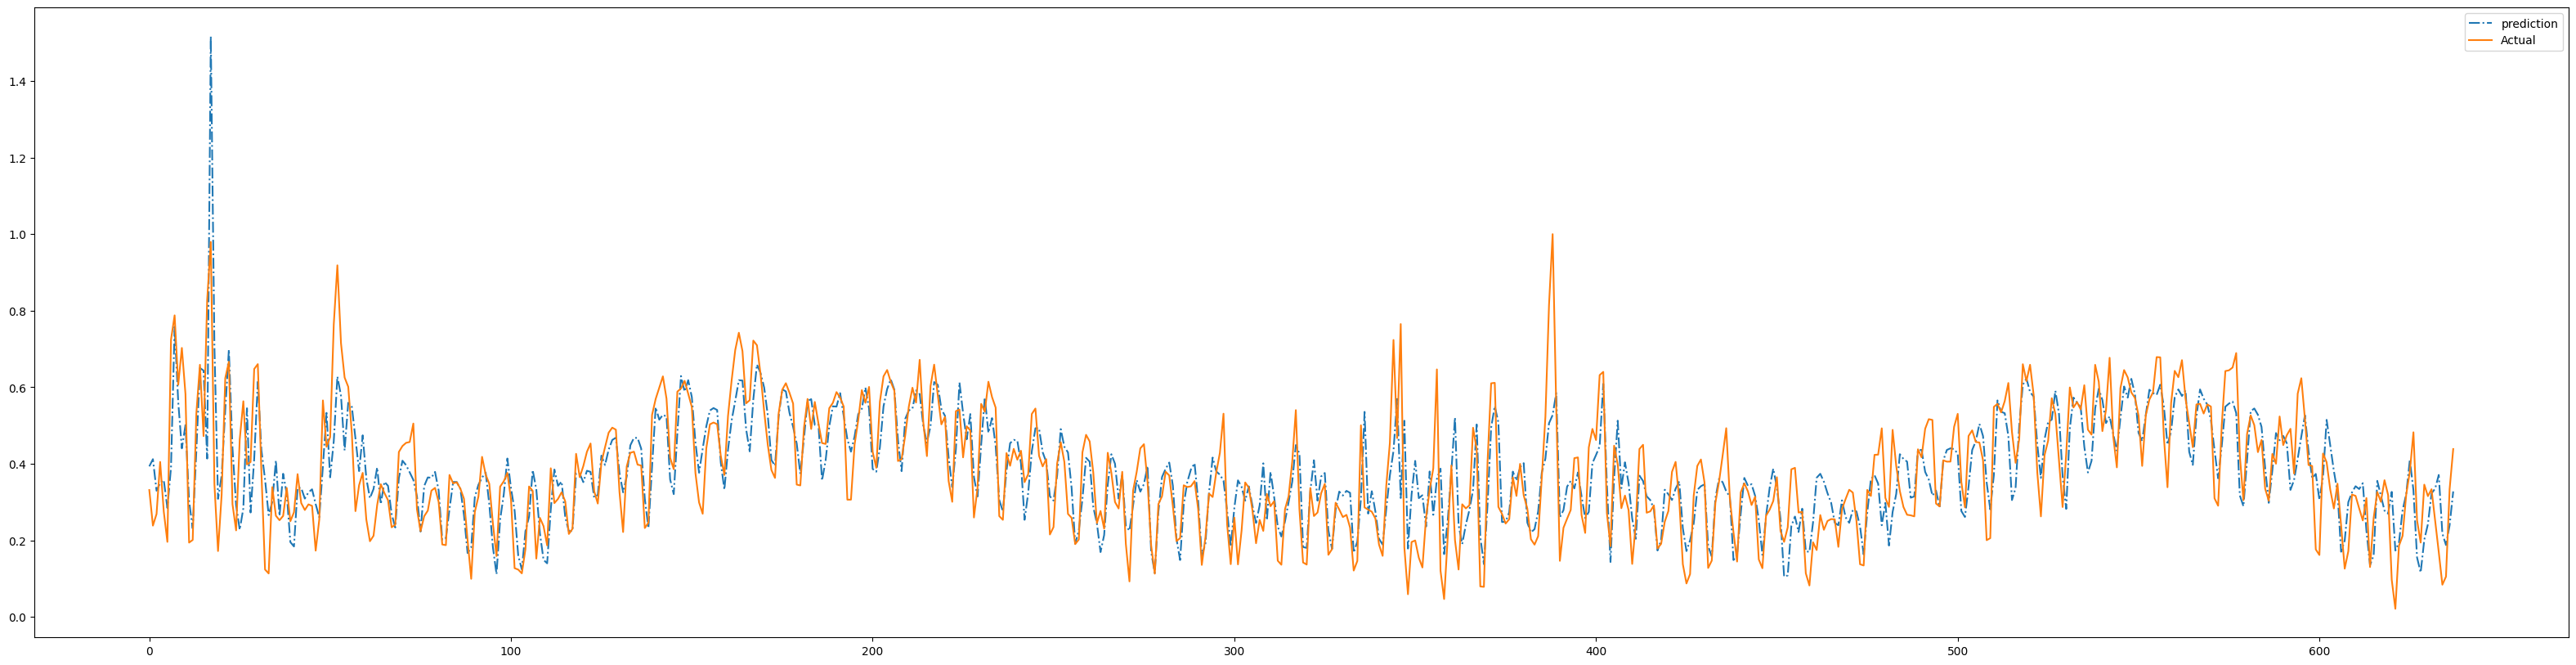

Mean_squared_error: 0.009662655011450546
Mean_absolute_error: 0.07201690870793269
Root mean squared error: 0.09829880473052836


In [12]:
test_prediction = best_LSTM.predict(X_test)
# train_results = pd.DataFrame(data={'Train_prediction': train_prediction, 'Actual result': y_train})
# train_results
plt.rcParams["figure.figsize"] = (40,10)
plt.plot(test_prediction, linestyle = 'dashdot', label ='prediction')
plt.plot(y_test, label ='Actual')
plt.legend()
plt.show()

from sklearn.metrics import mean_squared_error, mean_absolute_error

print('Mean_squared_error:', mean_squared_error(y_test, test_prediction))
print('Mean_absolute_error:', mean_absolute_error(y_test, test_prediction))
print('Root mean squared error:', np.sqrt(mean_squared_error(y_test, test_prediction)))

### Random Forest

In [13]:
train = scaled_df.loc[scaled_df.index < 1461]
test = scaled_df.loc[scaled_df.index >= 1461]
print(train)
print(test)
x_train = train.drop(labels='demand', axis=1)
y_train = train['demand']
x_test = test.drop(labels='demand', axis=1)
y_test = test['demand']
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

        demand       RRP  min_temperature  max_temperature  solar_exposure  \
0     0.169948  0.006960         0.463504         0.518841        0.702454   
1     0.520242  0.008608         0.540146         0.863768        0.800613   
2     0.668613  0.008921         0.708029         0.846377        0.791411   
3     0.224830  0.006823         0.572993         0.359420        0.751534   
4     0.386139  0.007200         0.525547         0.376812        0.920245   
...        ...       ...              ...              ...             ...   
1456  0.521915  0.023791         0.569343         0.823188        0.877301   
1457  0.569627  0.027995         0.777372         0.794203        0.564417   
1458  0.271107  0.021467         0.744526         0.431884        0.153374   
1459  0.169701  0.019809         0.642336         0.397101        0.282209   
1460  0.213741  0.019969         0.609489         0.420290        0.938650   

      rainfall  holiday  school_day  
0     0.000000        1  

In [14]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

rf_model = RandomForestRegressor(n_jobs=-1)
param_grid = {
    "n_estimators": np.arange(100, 1500, 100),
    "max_depth": np.arange(6, 20, 1),
    "max_leaf_nodes": np.arange(12, 20, 1),
#    'max_features': ['sqrt', 'log2', None],
}

rdms = RandomizedSearchCV(rf_model, param_grid, scoring='neg_mean_absolute_error', verbose = 2, cv=10)
rdms.fit(x_train, y_train)
print(rdms.best_score_)
print(rdms.best_params_)
print(rdms.best_estimator_)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
[CV] END ..max_depth=14, max_leaf_nodes=15, n_estimators=800; total time=   0.5s
[CV] END ..max_depth=14, max_leaf_nodes=15, n_estimators=800; total time=   0.4s
[CV] END ..max_depth=14, max_leaf_nodes=15, n_estimators=800; total time=   0.4s
[CV] END ..max_depth=14, max_leaf_nodes=15, n_estimators=800; total time=   0.4s
[CV] END ..max_depth=14, max_leaf_nodes=15, n_estimators=800; total time=   0.4s
[CV] END ..max_depth=14, max_leaf_nodes=15, n_estimators=800; total time=   0.4s
[CV] END ..max_depth=14, max_leaf_nodes=15, n_estimators=800; total time=   0.4s
[CV] END ..max_depth=14, max_leaf_nodes=15, n_estimators=800; total time=   0.4s
[CV] END ..max_depth=14, max_leaf_nodes=15, n_estimators=800; total time=   0.4s
[CV] END ..max_depth=14, max_leaf_nodes=15, n_estimators=800; total time=   0.4s
[CV] END ..max_depth=13, max_leaf_nodes=19, n_estimators=800; total time=   0.4s
[CV] END ..max_depth=13, max_leaf_nodes=19, n_

In [15]:
# {'n_estimators': 1100, 'max_leaf_nodes': 14, 'max_features': None, 'max_depth': 11}
# {'n_estimators': 400, 'max_leaf_nodes': 14, 'max_features': None, 'max_depth': 19}
# {'n_estimators': 500, 'max_leaf_nodes': 18, 'max_features': None, 'max_depth': 6}
# {'n_estimators': 700, 'max_leaf_nodes': 12, 'max_features': None, 'max_depth': 15}
# {'n_estimators': 100, 'max_leaf_nodes': 17, 'max_features': None, 'max_depth': 6}
# {'n_estimators': 800, 'max_leaf_nodes': 19, 'max_depth': 11}
# {'n_estimators': 1000, 'max_leaf_nodes': 19, 'max_depth': 8}
# {'n_estimators': 700, 'max_leaf_nodes': 18, 'max_depth': 7}
# -0.008783526035931919
# {'n_estimators': 300, 'max_leaf_nodes': 19, 'max_depth': 14}
# -0.008521678999174397
# {'n_estimators': 600, 'max_leaf_nodes': 16, 'max_depth': 9}
# -0.009946187741837993
# {'n_estimators': 300, 'max_leaf_nodes': 17, 'max_depth': 14}
# -0.009344037853001887
# {'n_estimators': 1200, 'max_leaf_nodes': 19, 'max_depth': 19}
# -0.008496487012060117
# {'n_estimators': 800, 'max_leaf_nodes': 18, 'max_depth': 11}
# -0.008878021055771953
# {'n_estimators': 600, 'max_leaf_nodes': 16, 'max_depth': 6}
# -0.009957689230692074
# {'n_estimators': 1000, 'max_leaf_nodes': 19, 'max_depth': 9}
# -0.008515829481855386
# {'n_estimators': 1000, 'max_leaf_nodes': 19, 'max_depth': 8}
# -0.008494167941168432

In [16]:
tune_result = "\n Best Hyper Parameters: ", rdms.best_params_,"\n", "Best estimator: ", rdms.best_estimator_,"\n"
print (tune_result)

##('\n Best Hyper Parameters: ', {'n_estimators': 1000, 'max_leaf_nodes': 19, 'max_depth': 8}, '\n', 'Best estimator: ', RandomForestRegressor(max_depth=8, max_leaf_nodes=19, n_estimators=1000,
##                      n_jobs=-1), '\n')

('\n Best Hyper Parameters: ', {'n_estimators': 800, 'max_leaf_nodes': 19, 'max_depth': 13}, '\n', 'Best estimator: ', RandomForestRegressor(max_depth=13, max_leaf_nodes=19, n_estimators=800,
                      n_jobs=-1), '\n')


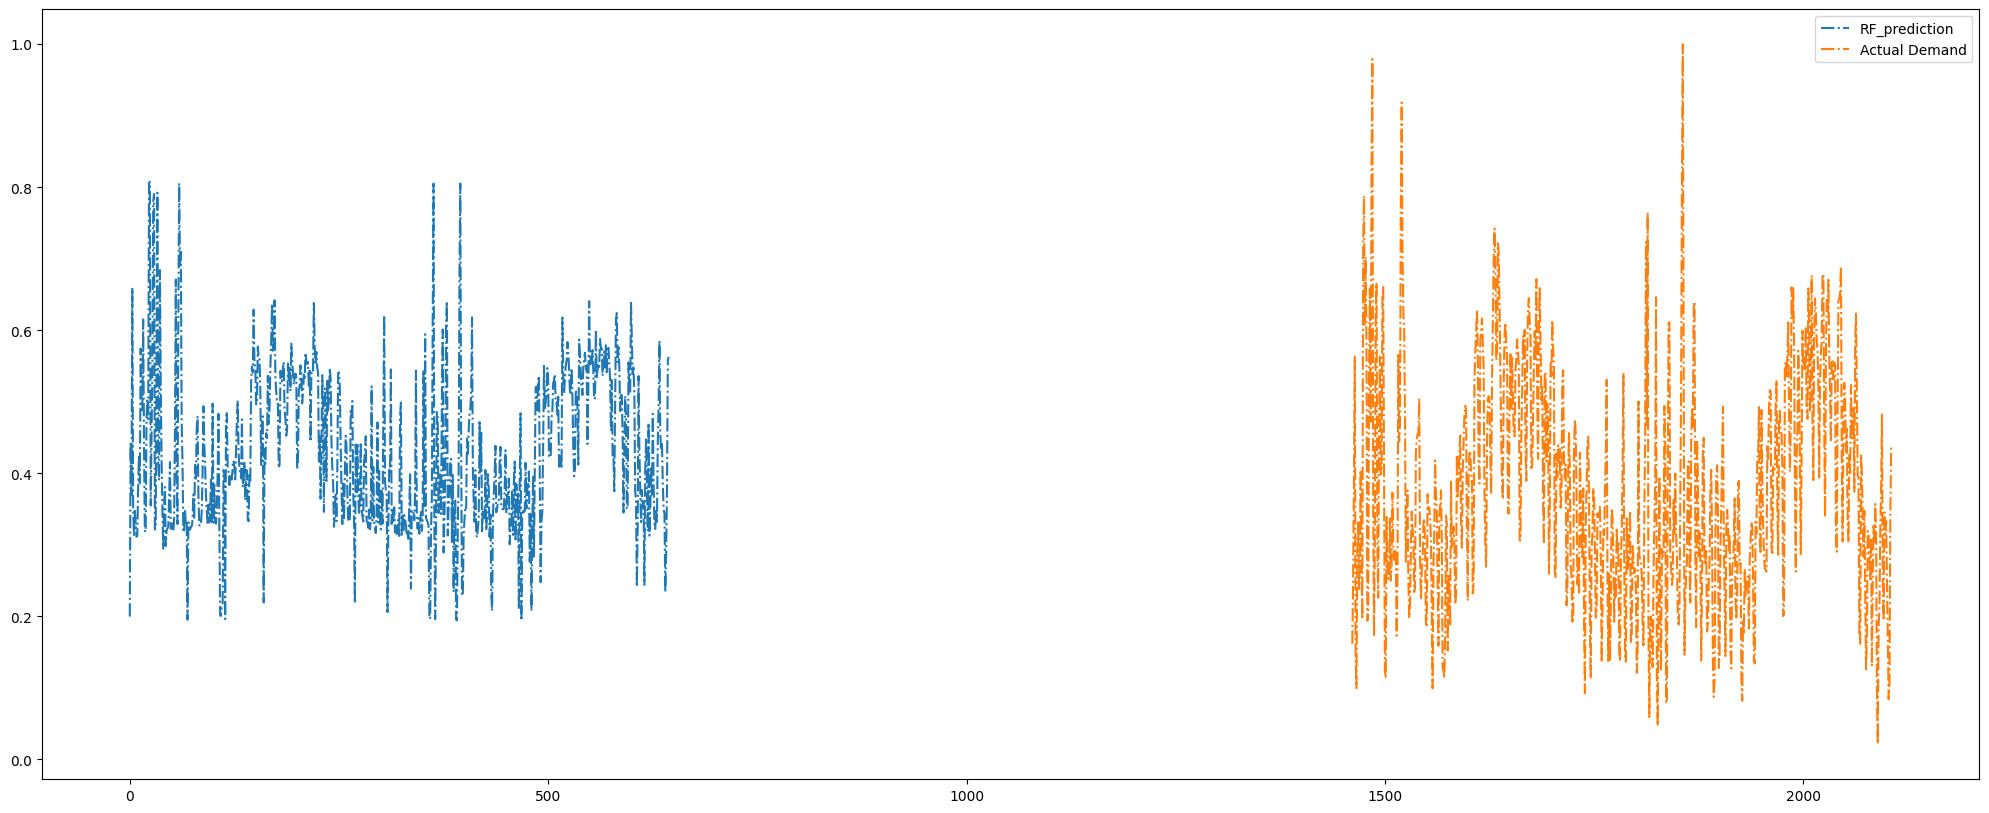

Mean_squared_error: 0.012494281705204469
Mean_absolute_error: 0.0882645245799679
Root mean squared error: 0.11177782295788583


(array([0.19959941, 0.44275455, 0.36983473, 0.65957852, 0.35185515,
        0.31184786, 0.34753167, 0.33172374, 0.31131486, 0.31331157,
        0.38214778, 0.4258524 , 0.3862105 , 0.57455272, 0.50228257,
        0.48810702, 0.61507777, 0.44009033, 0.31975239, 0.31786555,
        0.47623495, 0.50454725, 0.47589982, 0.80604472, 0.80771788,
        0.35490766, 0.4508239 , 0.55134799, 0.78031105, 0.79071958,
        0.32123566, 0.32329666, 0.56741889, 0.79240918, 0.41395251,
        0.38994562, 0.68420171, 0.52492586, 0.41750472, 0.34827804,
        0.29459138, 0.35388511, 0.38068572, 0.29825378, 0.32059461,
        0.32260921, 0.32539413, 0.36615422, 0.41561833, 0.32224893,
        0.32540771, 0.32972986, 0.31819799, 0.33821332, 0.46119461,
        0.6709    , 0.39808399, 0.32900335, 0.60980883, 0.80565092,
        0.69051461, 0.70987018, 0.47153913, 0.41366941, 0.31712284,
        0.32143397, 0.34922322, 0.3271968 , 0.33377068, 0.19534882,
        0.33126752, 0.33007271, 0.32106533, 0.32

In [17]:
rf_tuned = rdms.best_estimator_
rf_tuned_pred = rf_tuned.predict(x_test)

plt.rcParams["figure.figsize"] = (25,10)
plt.plot(rf_tuned_pred ,label = "RF_prediction", linestyle = 'dashdot')
plt.plot(y_test, label = 'Actual Demand', linestyle = 'dashdot')
plt.legend(loc = 'upper right')
plt.show()

from sklearn.metrics import mean_squared_error, mean_absolute_error

print('Mean_squared_error:', mean_squared_error(y_test, rf_tuned_pred))
print('Mean_absolute_error:', mean_absolute_error(y_test, rf_tuned_pred))
print('Root mean squared error:', np.sqrt(mean_squared_error(y_test, rf_tuned_pred)))
rf_tuned_pred, y_test

In [18]:
rf_tuned_pred

array([0.19959941, 0.44275455, 0.36983473, 0.65957852, 0.35185515,
       0.31184786, 0.34753167, 0.33172374, 0.31131486, 0.31331157,
       0.38214778, 0.4258524 , 0.3862105 , 0.57455272, 0.50228257,
       0.48810702, 0.61507777, 0.44009033, 0.31975239, 0.31786555,
       0.47623495, 0.50454725, 0.47589982, 0.80604472, 0.80771788,
       0.35490766, 0.4508239 , 0.55134799, 0.78031105, 0.79071958,
       0.32123566, 0.32329666, 0.56741889, 0.79240918, 0.41395251,
       0.38994562, 0.68420171, 0.52492586, 0.41750472, 0.34827804,
       0.29459138, 0.35388511, 0.38068572, 0.29825378, 0.32059461,
       0.32260921, 0.32539413, 0.36615422, 0.41561833, 0.32224893,
       0.32540771, 0.32972986, 0.31819799, 0.33821332, 0.46119461,
       0.6709    , 0.39808399, 0.32900335, 0.60980883, 0.80565092,
       0.69051461, 0.70987018, 0.47153913, 0.41366941, 0.31712284,
       0.32143397, 0.34922322, 0.3271968 , 0.33377068, 0.19534882,
       0.33126752, 0.33007271, 0.32106533, 0.32537515, 0.32596

In [19]:
y_test

1461    0.161743
1462    0.249841
1463    0.393822
1464    0.563282
1465    0.142222
          ...   
2101    0.169373
2102    0.083949
2103    0.105040
2104    0.333285
2105    0.438446
Name: demand, Length: 645, dtype: float64

In [20]:
x_test

,RRP,min_temperature,max_temperature,solar_exposure,rainfall,holiday,school_day
1461,0.018578,0.543796,0.498551,0.950920,0.000000,1,0
1462,0.021572,0.649635,0.382609,0.785276,0.000000,0,0
1463,0.029294,0.558394,0.594203,0.825153,0.000000,0,0
1464,0.027898,0.635036,0.973913,0.819018,0.000000,0,0
1465,0.019661,0.613139,0.353623,0.374233,0.007326,0,0
...,...,...,...,...,...,...,...
2101,0.000000,0.445255,0.492754,0.653374,0.000000,0,0
2102,0.000898,0.613139,0.591304,0.585890,0.000000,0,0
2103,0.006823,0.470803,0.594203,0.236196,0.000000,0,0
2104,0.009404,0.310219,0.107246,0.202454,0.234432,0,0


### SARIMA

In [21]:
fileName = 'complete_dataset.csv'
df = pd.read_csv(fileName, index_col='date', parse_dates=True).asfreq("D")
df.head()

,demand,RRP,demand_pos_RRP,RRP_positive,demand_neg_RRP,RRP_negative,frac_at_neg_RRP,min_temperature,max_temperature,solar_exposure,rainfall,school_day,holiday
date,,,,,,,,,,,,,
2015-01-01,99635.030,25.633696,97319.240,26.415953,2315.790,-7.240000,0.020833,13.3,26.9,23.6,0.0,N,Y
2015-01-02,129606.010,33.138988,121082.015,38.837661,8523.995,-47.809777,0.062500,15.4,38.8,26.8,0.0,N,N
2015-01-03,142300.540,34.564855,142300.540,34.564855,0.000,0.000000,0.000000,20.0,38.2,26.5,0.0,N,N
2015-01-04,104330.715,25.005560,104330.715,25.005560,0.000,0.000000,0.000000,16.3,21.4,25.2,4.2,N,N
2015-01-05,118132.200,26.724176,118132.200,26.724176,0.000,0.000000,0.000000,15.0,22.0,30.7,0.0,N,N


<Axes: xlabel='date'>

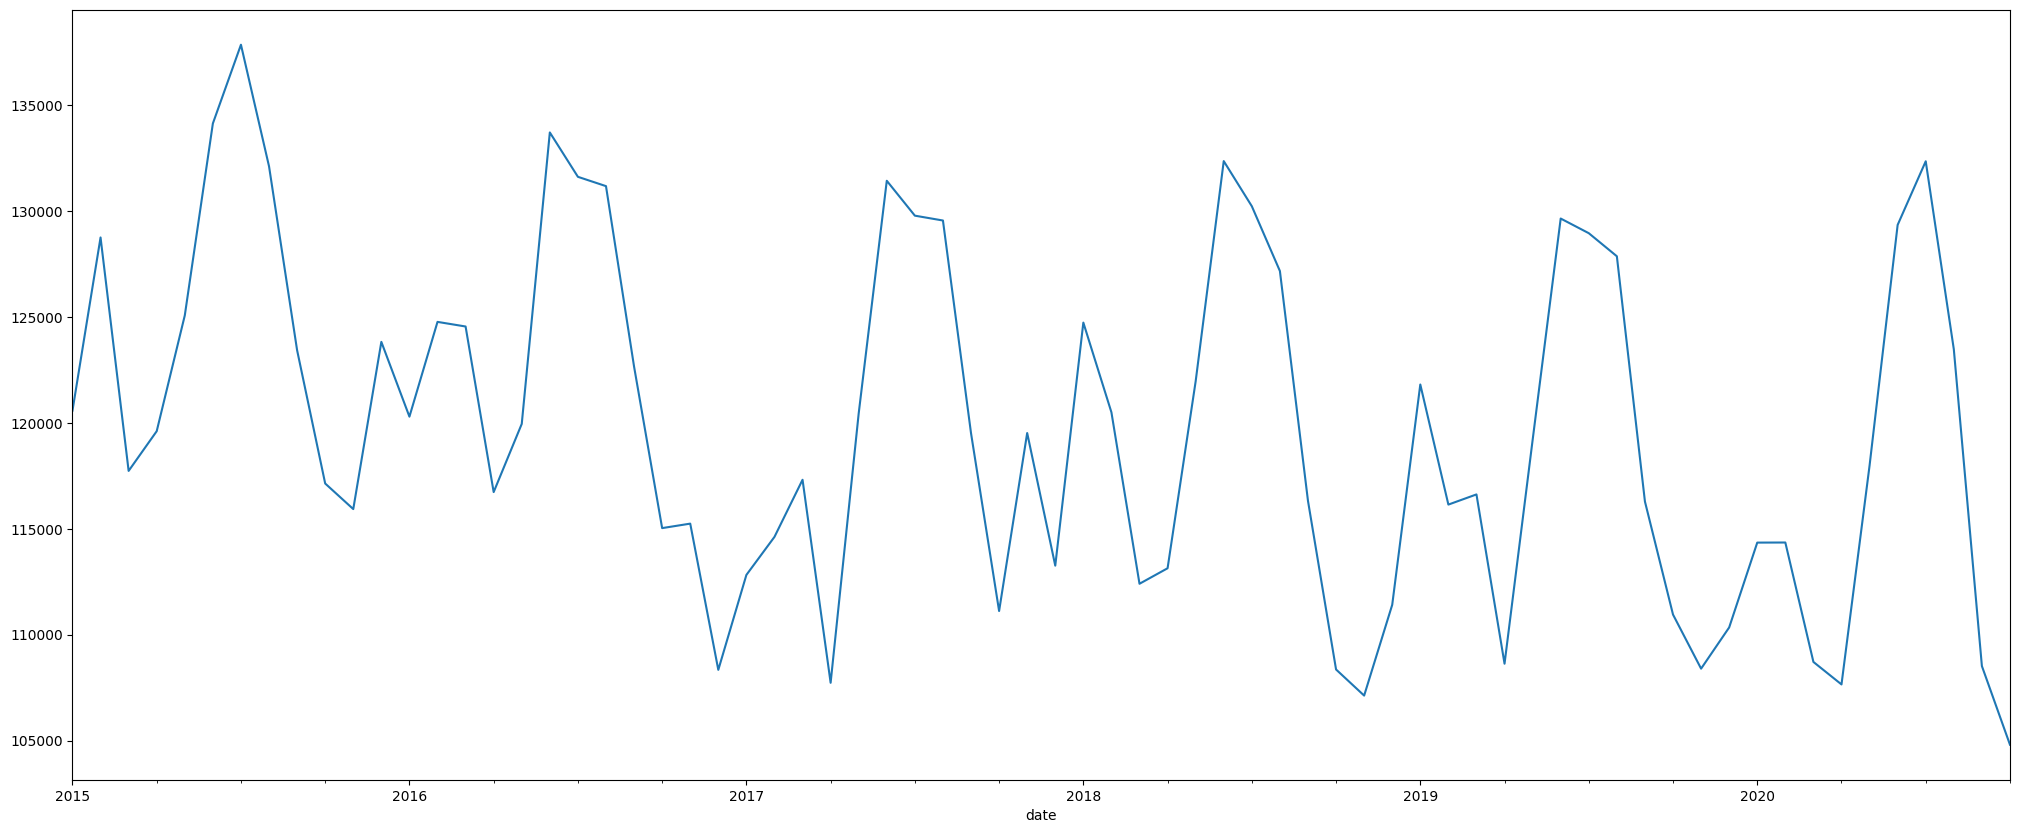

In [22]:
monthly_df = df['demand'].resample('M').mean()
monthly_df.plot()

In [23]:
monthly_df.index

DatetimeIndex(['2015-01-31', '2015-02-28', '2015-03-31', '2015-04-30',
               '2015-05-31', '2015-06-30', '2015-07-31', '2015-08-31',
               '2015-09-30', '2015-10-31', '2015-11-30', '2015-12-31',
               '2016-01-31', '2016-02-29', '2016-03-31', '2016-04-30',
               '2016-05-31', '2016-06-30', '2016-07-31', '2016-08-31',
               '2016-09-30', '2016-10-31', '2016-11-30', '2016-12-31',
               '2017-01-31', '2017-02-28', '2017-03-31', '2017-04-30',
               '2017-05-31', '2017-06-30', '2017-07-31', '2017-08-31',
               '2017-09-30', '2017-10-31', '2017-11-30', '2017-12-31',
               '2018-01-31', '2018-02-28', '2018-03-31', '2018-04-30',
               '2018-05-31', '2018-06-30', '2018-07-31', '2018-08-31',
               '2018-09-30', '2018-10-31', '2018-11-30', '2018-12-31',
               '2019-01-31', '2019-02-28', '2019-03-31', '2019-04-30',
               '2019-05-31', '2019-06-30', '2019-07-31', '2019-08-31',
      

In [24]:
train = monthly_df.loc[monthly_df.index.get_level_values(0) <= '2018-12-31']
test = monthly_df[monthly_df.index.get_level_values(0) >= '2019-01-31']
train, test

(date
 2015-01-31    120576.860323
 2015-02-28    128754.107679
 2015-03-31    117730.704839
 2015-04-30    119606.603500
 2015-05-31    125072.101935
 2015-06-30    134137.917833
 2015-07-31    137856.058387
 2015-08-31    132113.753387
 2015-09-30    123427.208000
 2015-10-31    117135.675161
 2015-11-30    115927.911333
 2015-12-31    123824.128871
 2016-01-31    120292.740806
 2016-02-29    124767.840000
 2016-03-31    124549.920000
 2016-04-30    116731.018500
 2016-05-31    119950.549677
 2016-06-30    133713.506667
 2016-07-31    131618.328387
 2016-08-31    131178.282581
 2016-09-30    122656.683167
 2016-10-31    115029.608387
 2016-11-30    115241.024167
 2016-12-31    108336.597581
 2017-01-31    112818.727097
 2017-02-28    114614.890357
 2017-03-31    117311.886129
 2017-04-30    107725.249333
 2017-05-31    120448.647903
 2017-06-30    131431.604667
 2017-07-31    129783.944839
 2017-08-31    129554.926290
 2017-09-30    119511.055000
 2017-10-31    111114.919839
 2017-11

In [25]:
from pmdarima import auto_arima
search_fit = auto_arima(train,
                        trace=True,
                        m=12,
                        n_jobs=-1,
                        frequency = 30,
                        error_action='ignore')
search_fit.summary()

e:\Work\ITS_Capstone\ITS-Capstone-11522-23-14\venv\Lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,1,1)[12] intercept   : AIC=731.452, Time=0.68 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=724.257, Time=0.01 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=726.506, Time=0.14 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=726.612, Time=0.09 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=726.870, Time=0.01 sec
 ARIMA(0,0,0)(1,1,0)[12] intercept   : AIC=725.800, Time=0.02 sec
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=725.806, Time=0.02 sec
 ARIMA(0,0,0)(1,1,1)[12] intercept   : AIC=727.792, Time=0.10 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=726.346, Time=0.01 sec
 ARIMA(0,0,1)(0,1,0)[12] intercept   : AIC=725.514, Time=0.02 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=728.164, Time=0.03 sec

Best model:  ARIMA(0,0,0)(0,1,0)[12] intercept
Total fit time: 1.316 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                                SARIMAX Results                                 
================================================================================
Dep. Variable:                        y   No. Observations:                   48
Model:             SARIMAX(0, 1, 0, 12)   Log Likelihood                -360.129
Date:                  Mon, 25 Sep 2023   AIC                            724.257
Time:                          23:27:31   BIC                            727.424
Sample:                      01-31-2015   HQIC                           725.363
                           - 12-31-2018                                         
Covariance Type:                    opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -1957.6819    891.513     -2.196      0.028   -3705.015    -210.349
sigma2      2.861e+07   5.83e+06      4.909      0.000    1.72e+07       4e+07
===================================================================================
Ljung-Box (L1) (Q):                   4.93   Jarque-Bera (JB):                 0.69
Prob(Q):                              0.03   Prob(JB):                         0.71
Heteroskedasticity (H):               1.50   Skew:                            -0.02
Prob(H) (two-sided):                  0.49   Kurtosis:                         3.68
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [26]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
# model_sarima = SARIMAX(train['demand'], order())
predictions = pd.Series(search_fit.predict(len(test)))
predictions.index = test.index
predictions[-5:]

date
2020-06-30    128445.449089
2020-07-31    126314.362062
2020-08-31    123254.143836
2020-09-30    112400.240422
2020-10-31    104438.172546
Freq: M, dtype: float64

<Axes: xlabel='date'>

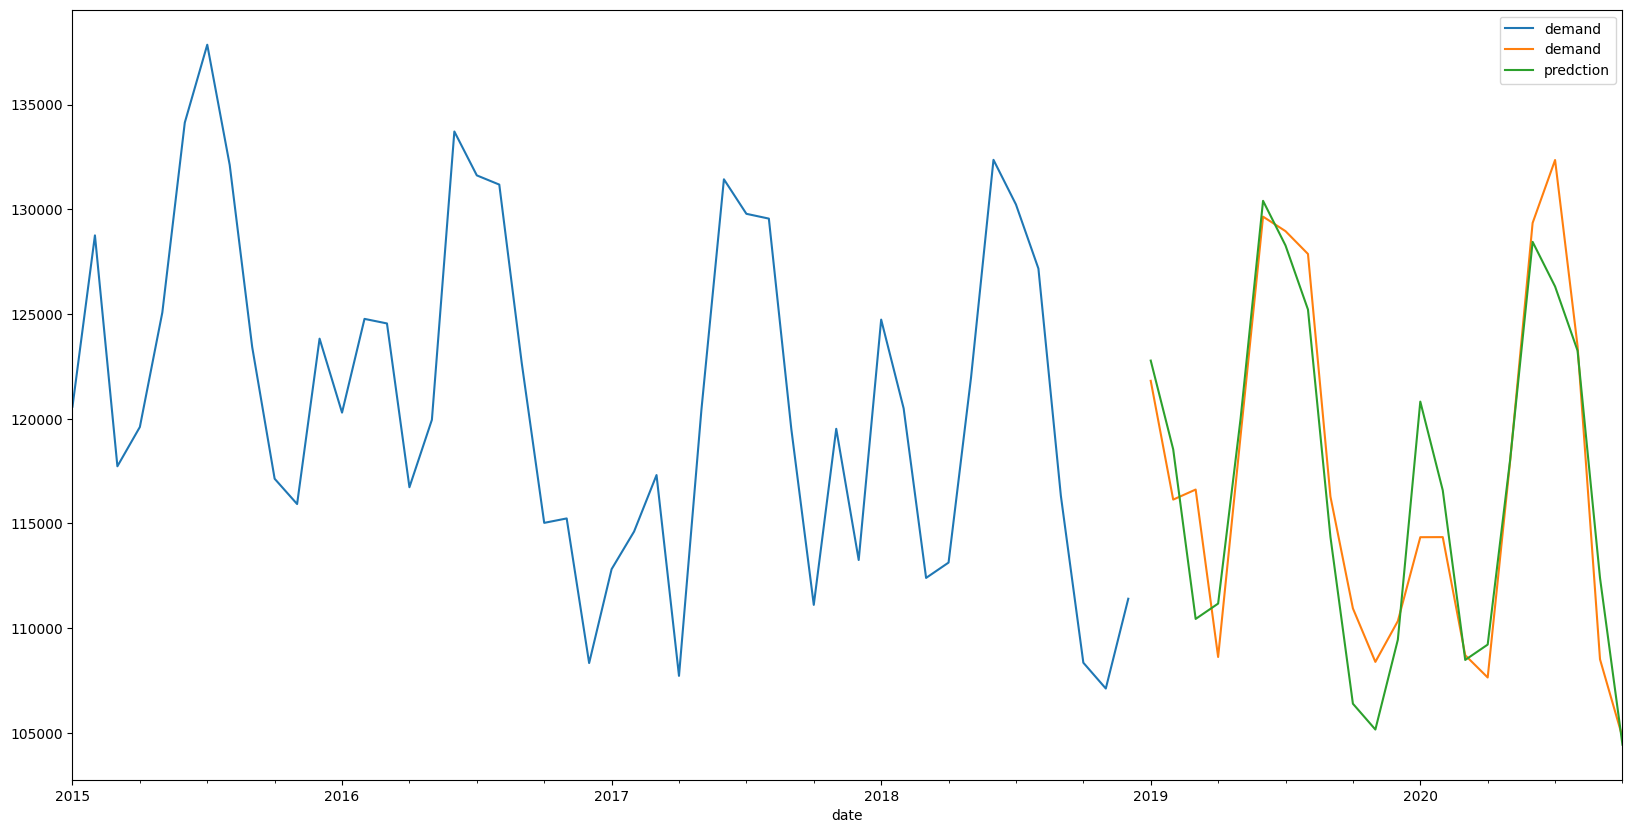

In [27]:
train.plot(figsize=(20,10), legend = True)
test.plot(figsize=(20,10), legend = True)
predictions.plot(legend = True, label = 'predction')

Text(0, 0.5, 'demand')

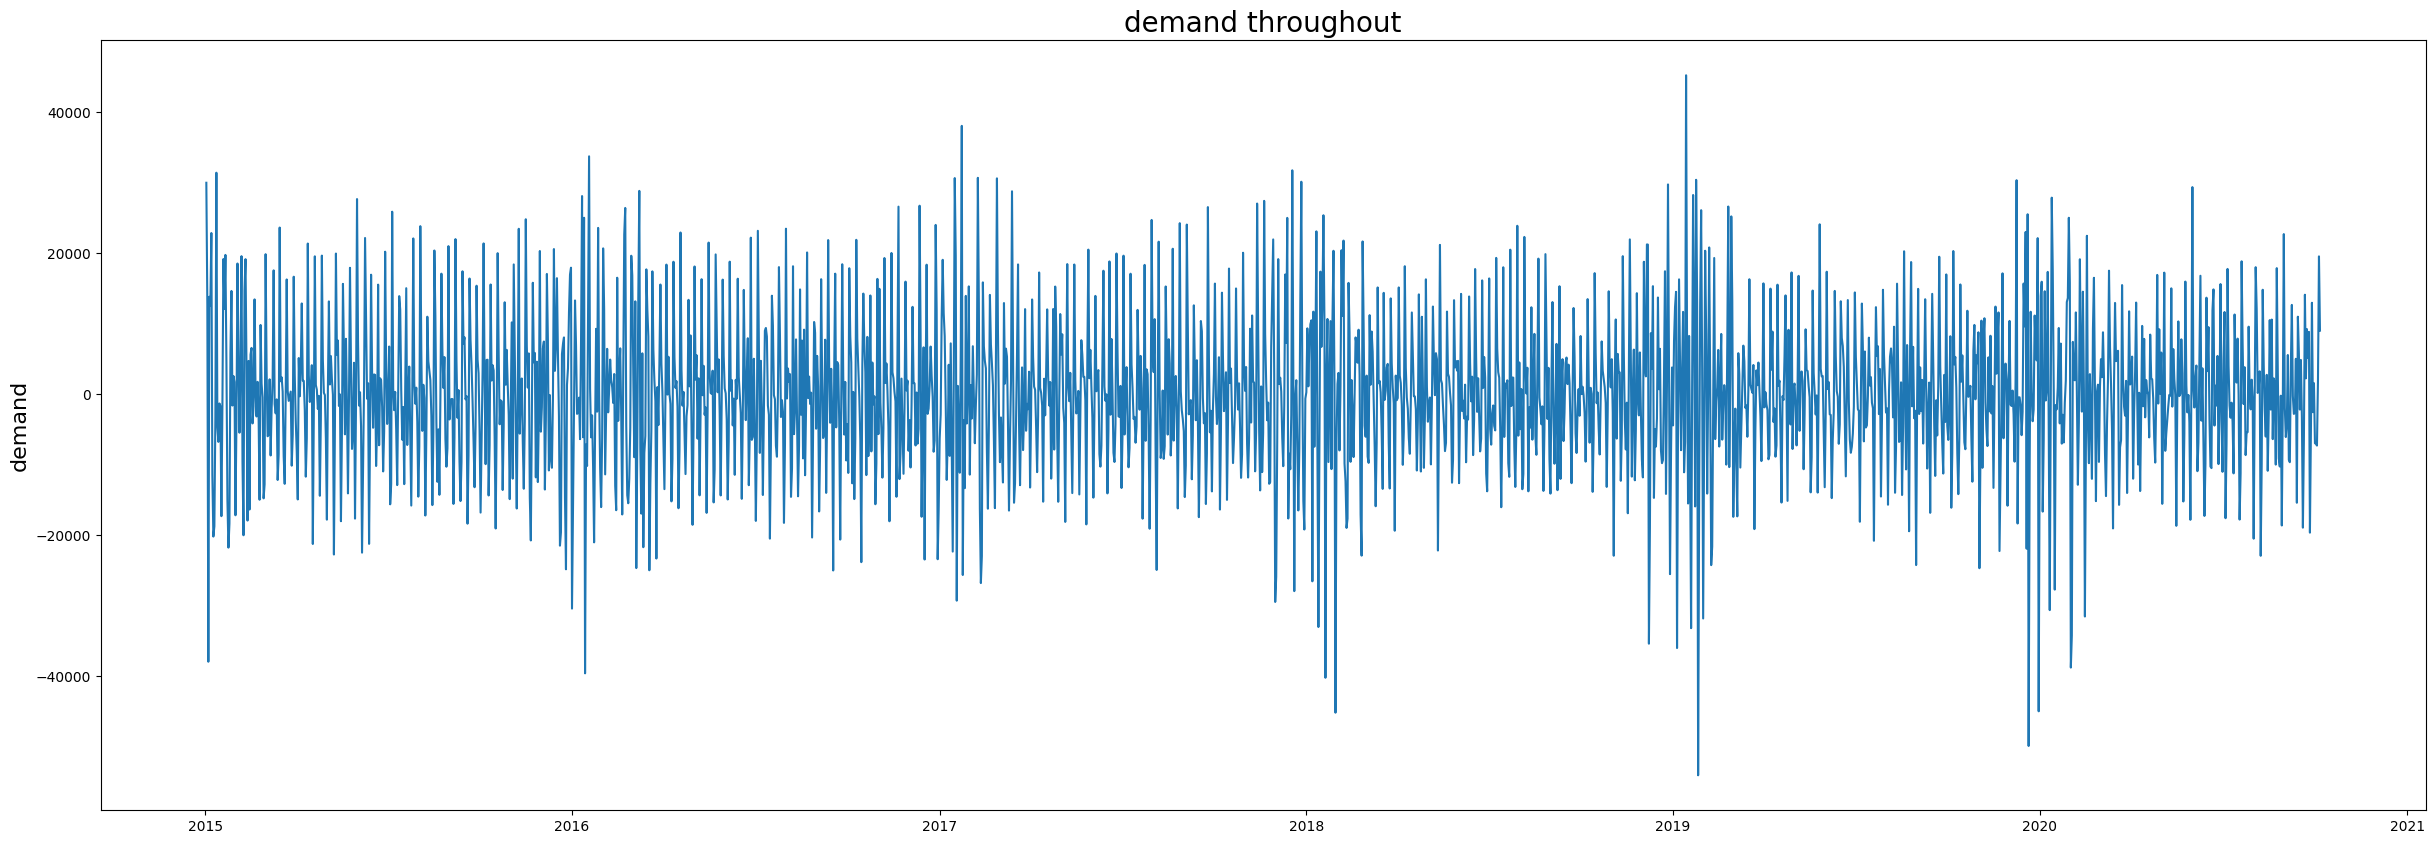

In [28]:
first_diff = df['demand'].diff()[1:]
plt.figure(figsize=(30,10))
plt.plot(first_diff)
plt.title('demand throughout', fontsize=20)
plt.ylabel('demand', fontsize=16)

ACF

[ 1.          0.06851388 -0.37427892 -0.17520923 -0.11106592 -0.21881923
  0.07621099  0.49166944  0.06155536 -0.23152074 -0.08219572 -0.08096109
 -0.21738747  0.07195055  0.46709857  0.06689513 -0.20840272 -0.09980835
 -0.09505323 -0.20029926  0.05682447  0.4787611   0.08323631 -0.20578437
 -0.11522668 -0.09206546 -0.2231981   0.06441868  0.48617632  0.0812172
 -0.22233069 -0.09565579 -0.08346485 -0.22804393]


<BarContainer object of 34 artists>

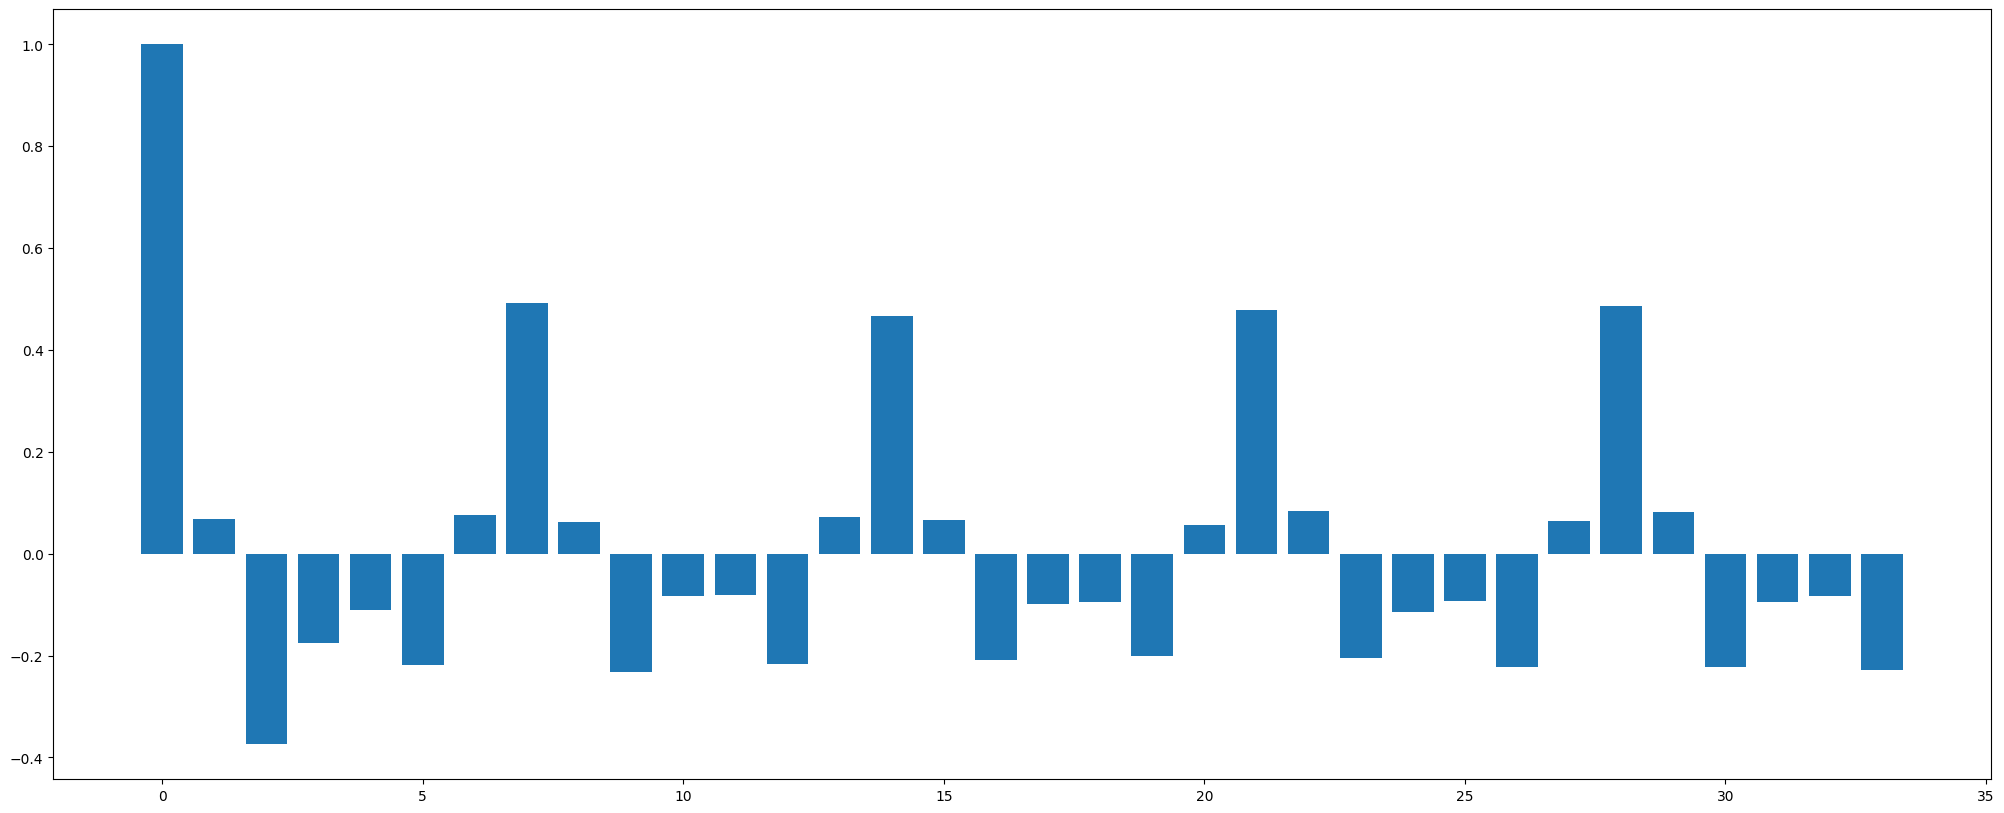

In [29]:
from statsmodels.tsa.stattools import acf, pacf
acf_vals = acf(first_diff)
print(acf_vals)
num_lags = 34
plt.bar(range(num_lags), acf_vals[:num_lags])

PACF

<BarContainer object of 34 artists>

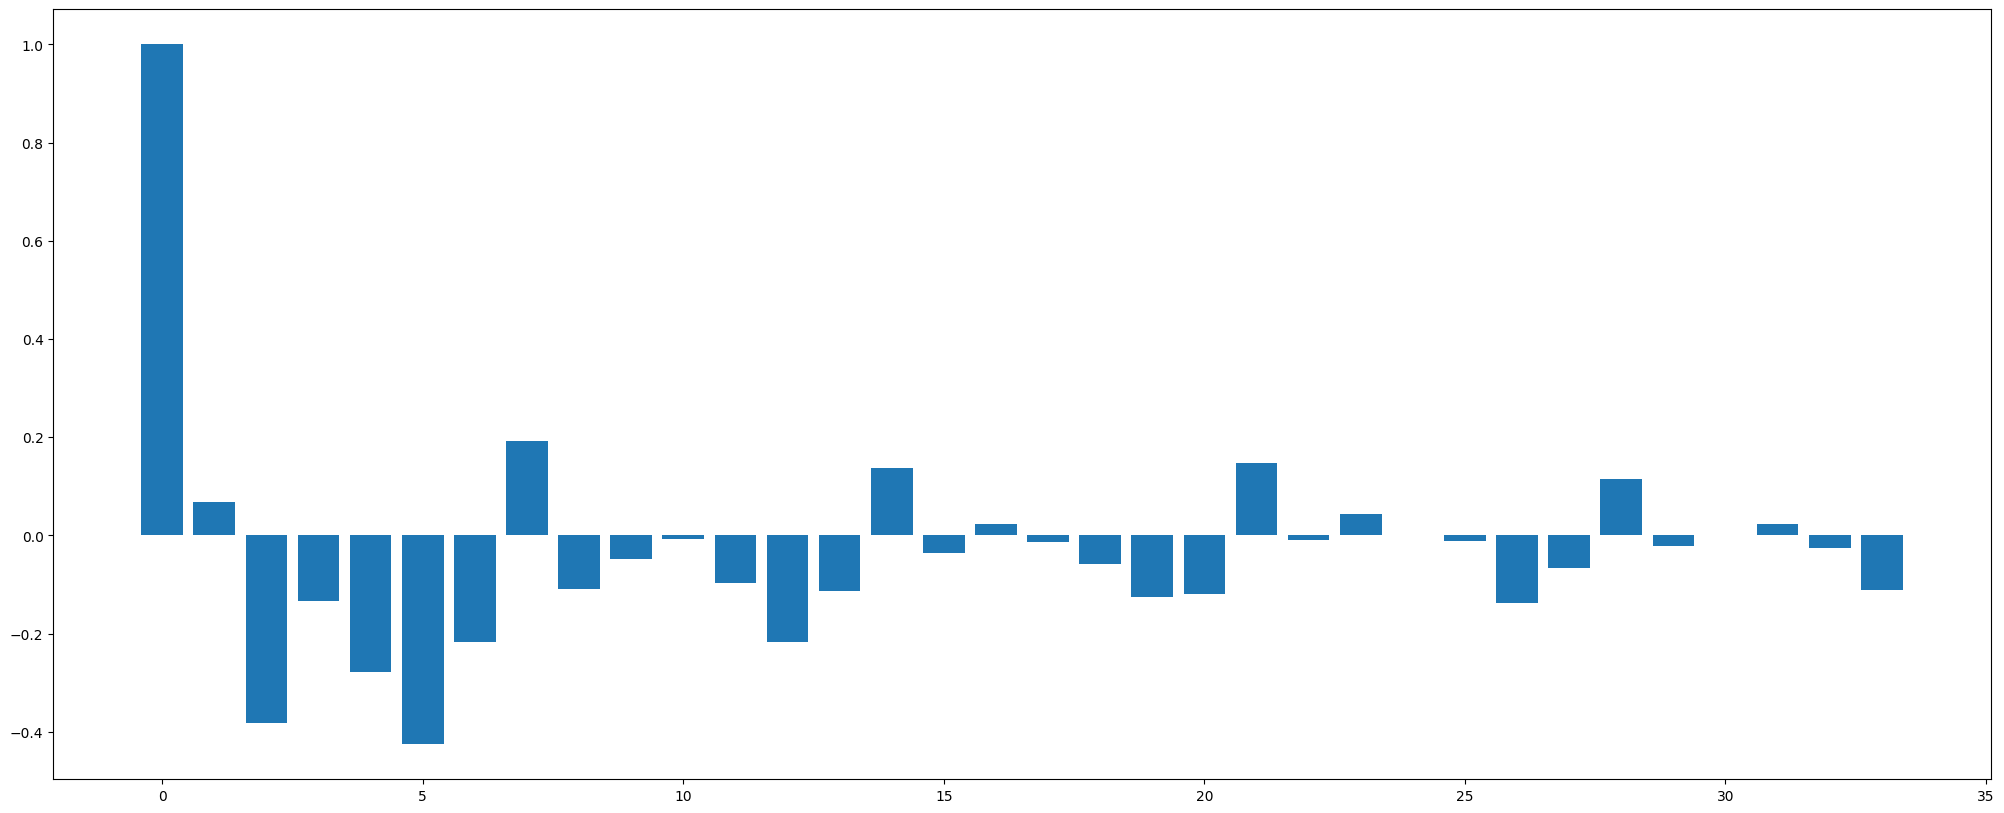

In [30]:
pacf_vals = pacf(first_diff)
num_lags = 34
plt.bar(range(num_lags), pacf_vals[:num_lags])

In [45]:
order = (1,1,1)
seasonal_order = (1, 0, 1, 7)
model_sarima = SARIMAX(y_train, order=order, seasonal_order=seasonal_order)
model_fit = model_sarima.fit(low_memory=True)
model_fit.summary()

e:\Work\ITS_Capstone\ITS-Capstone-11522-23-14\venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                            demand   No. Observations:                 1461
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 7)   Log Likelihood                1556.428
Date:                           Mon, 25 Sep 2023   AIC                          -3102.856
Time:                                   23:35:05   BIC                          -3076.425
Sample:                                        0   HQIC                         -3092.996
                                          - 1461                                         
Covariance Type:                          approx                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6087      0.026     23.182      0.000       0.557       0.660
ma.L1         -0.9359      0.011    -87.678      0.000      -0.957      -0.915
ar.S.L7        0.9999      0.000   3574.270      0.000       0.999       1.000
ma.S.L7       -0.9853      0.012    -83.018      0.000      -1.009      -0.962
sigma2         0.0068      0.000     26.329      0.000       0.006       0.007
===================================================================================
Ljung-Box (L1) (Q):                  28.24   Jarque-Bera (JB):               677.53
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.98   Skew:                             0.17
Prob(H) (two-sided):                  0.79   Kurtosis:                         6.32
===================================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

<Axes: >

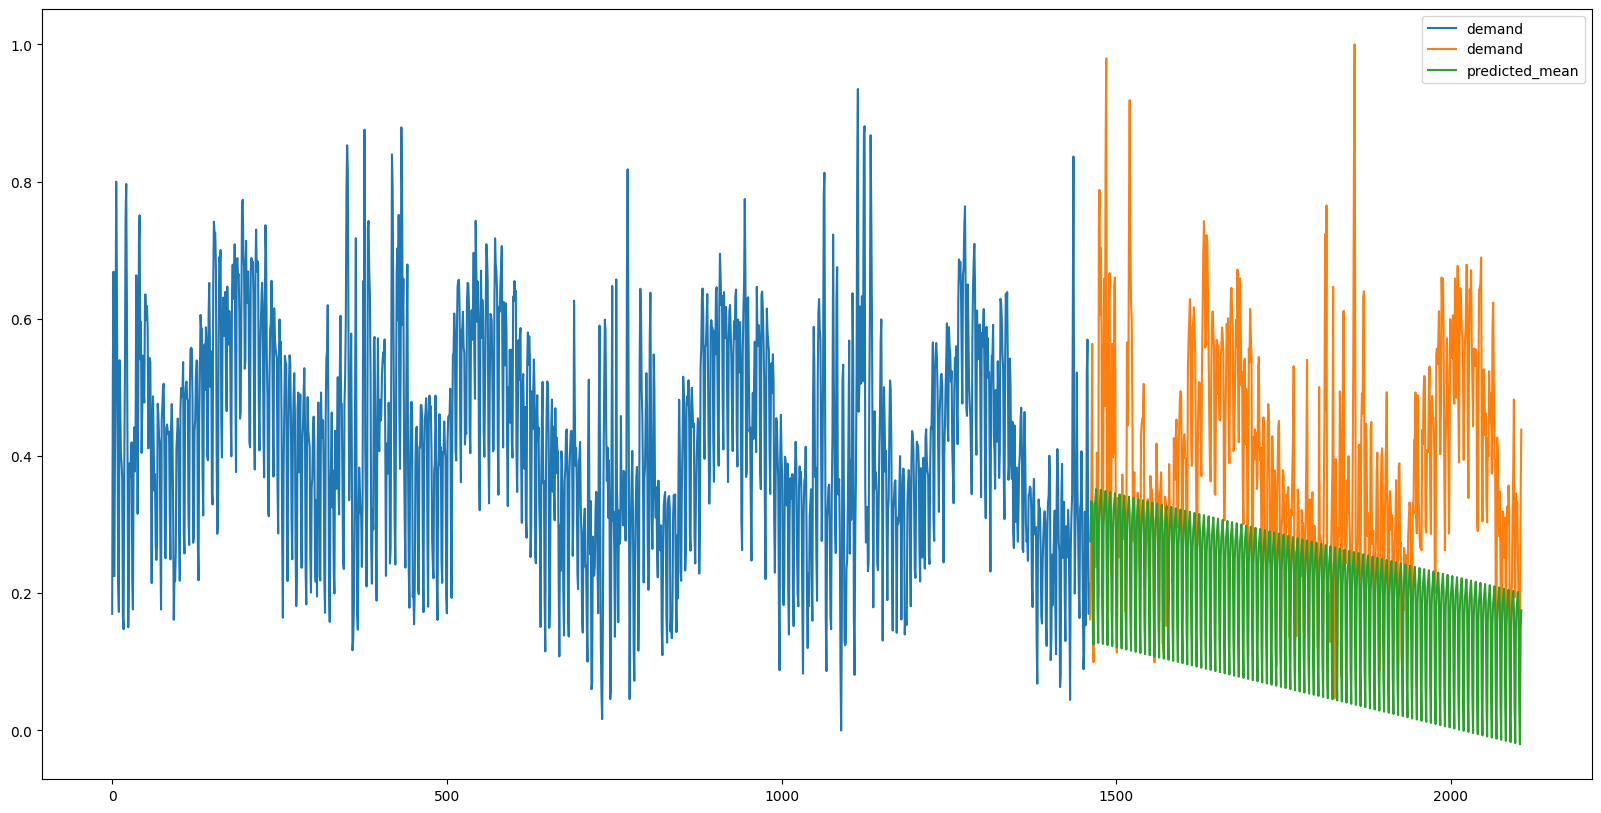

In [46]:
predictions = model_fit.forecast(len(y_test))
predictions = pd.Series(predictions, index=y_test.index)
y_train.plot(figsize=(20,10), legend = True)
y_test.plot(figsize=(20,10), legend = True)
predictions.plot(legend = True)